# Multitask Deep Learning

## Input Features

$Input = b_x + lenghts + h_{state}$

**Features in `b_x` include:**

- **Loan ID (`loan_id`)**: This is an identifier representing different loan instances.
- **installment, installment_timestep, state_cum_overduelength, remaining_debt, state_capital, state_interests, state_penalty**: These are features related to the loan's status and financial details.
- **gender, age, amount, num_loan, duration, year_ratio, diff_city, marriage, kids, month_in, housing, edu, motivation**: These are features describing the personal information and background of the loan applicant.
- **action_num_actual, installment_done, loan_done, recovery_rate_weighted**: These are features related to the loan operations and repayment status.

## Output

Multitask: Four tasks: 
* `State Prediction`: installment, remaining_debt, state_capital...
* `Installment Done Prediction` (Loss: MaskedBCE)
* `Loan Done Prediction` (Loss: MaskedBCE)
* `Reward Prediction?` (Loss: MaskedMSE)

## LSTM Approach

$$
\begin{array}{ll} \\
            i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
            f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
            g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
            o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
            c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
            h_t = o_t \odot \tanh(c_t) \\
\end{array} 
$$

In [1]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence



class MultitaskLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, varstate_size):
        super(MultitaskLSTM, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
        )
        self.state_layer = nn.Linear(hidden_size, varstate_size)
        self.installment_done_layer = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )
        self.loan_done_layer = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )
        self.reward_layer = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.ReLU()
        )

    def forward(self, x, x_lengths, h_state):
        # x (batch, time_step, input_size)
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, hidden_size)
        x = pack_padded_sequence(x, x_lengths, batch_first=True)
        r_out, h_state = self.lstm(x, h_state)
        paded_out, paded_lengths = pad_packed_sequence(r_out, batch_first=True)

        state_outs = []
        installment_done_outs = []
        loan_done_outs = []
        reward_outs = []
        # calculate output for each time step
        for time_step in range(paded_out.size(1)):
            state_outs.append(self.state_layer(paded_out[:, time_step, :]))
            installment_done_outs.append(
                self.installment_done_layer(paded_out[:, time_step, :]))
            loan_done_outs.append(
                self.loan_done_layer(paded_out[:, time_step, :]))
            reward_outs.append(self.reward_layer(paded_out[:, time_step, :]))
        return torch.stack(state_outs, dim=1), torch.stack(installment_done_outs, dim=1), torch.stack(loan_done_outs, dim=1), torch.stack(reward_outs, dim=1), h_state

In [10]:
from torchviz import make_dot
import torch

time_steps = 3
varstate_size = 7


input_size = 21  # args.input_size
LR = 0.001  # args.lr
batch_size = 64  # args.batch_size
hidden_size = 50  # args.hidden_size
alpha = 0.25  # args.alpha
epochs = 100  # args.epoch

model = MultitaskLSTM(input_size, hidden_size, varstate_size)

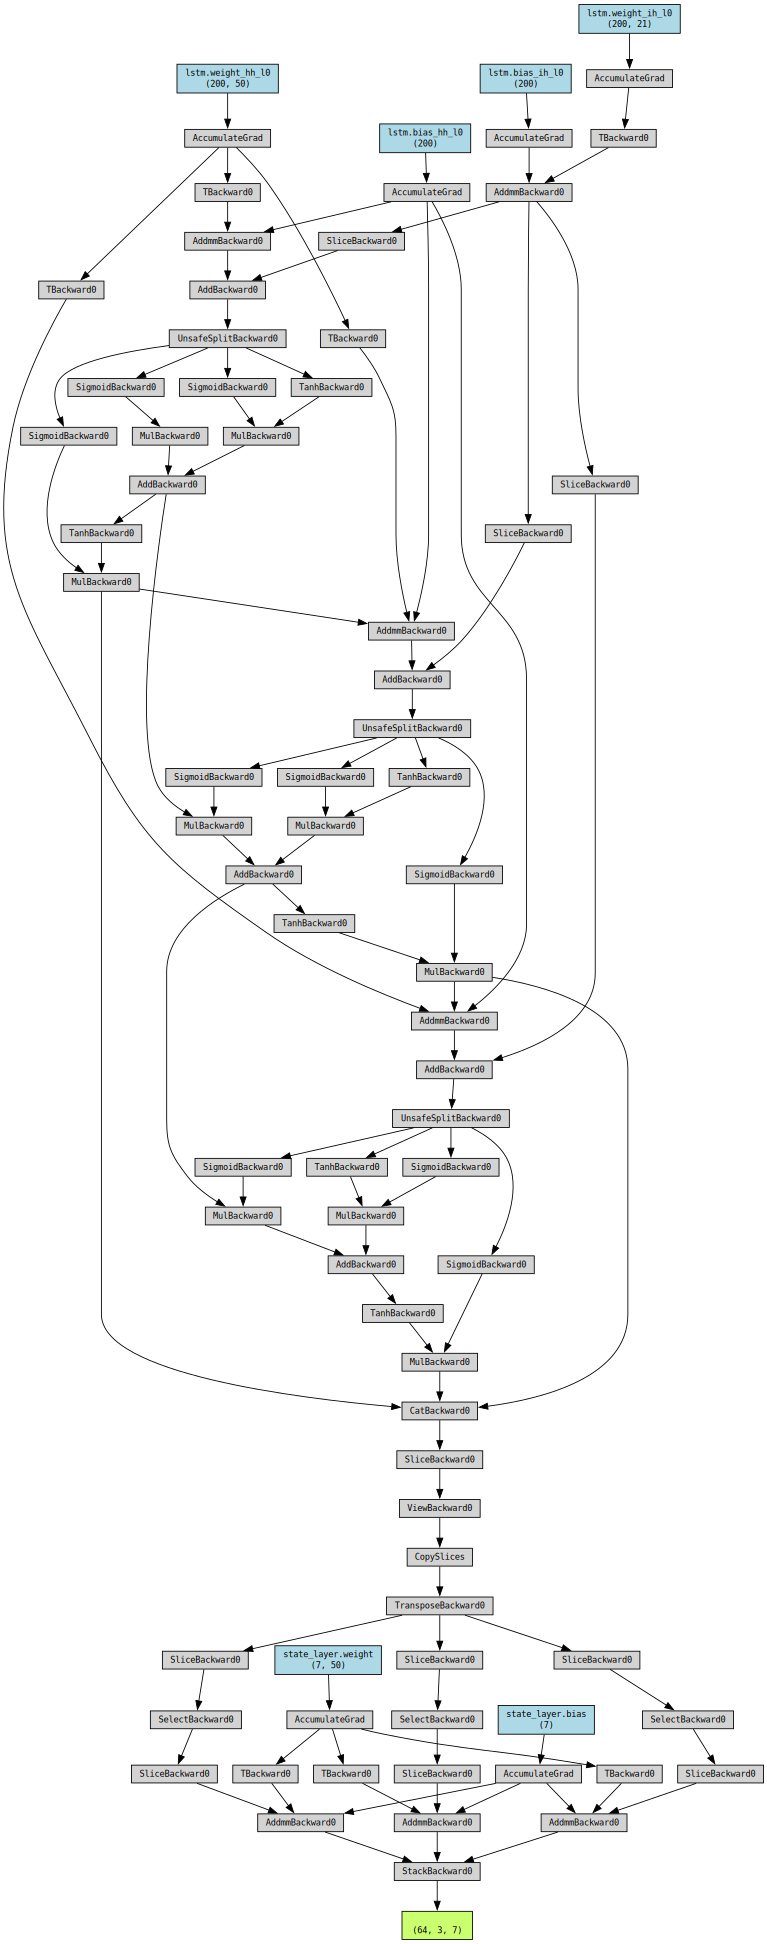

In [14]:
# Visualize the NN model
x = torch.randn(batch_size, time_steps, input_size)
x_lengths = torch.tensor([time_steps]*batch_size)
h_state = (torch.zeros(1, batch_size, hidden_size),
           torch.zeros(1, batch_size, hidden_size))

# Forward pass
y = model(x, x_lengths, h_state)
make_dot(y[0], params=dict(model.named_parameters()))

In [ ]:
# Very hard to understand the data structure
# Why use pickle???
import pickle


data_path = './Data/simulator_train_batch.pkl'
pkl_file = open(data_path, 'rb')
train_batch_data = pickle.load(pkl_file)
pkl_file.close()

# train_batch_data

In [ ]:
train_batch_data